In [1]:
import torch
import torch.nn as nn
import os # dataset
import pandas as pd # dataset
from PIL import Image # dataset
import torchvision.transforms as transforms # train
import torch.optim as optim # train
import torchvision.transforms.functional as FT # train
#from tqdm import tqdm # train
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import DataLoader # train
import numpy as np # box utils
import matplotlib.pyplot as plt # box utils
import matplotlib.patches as patches # box utils
from collections import Counter # box utils

from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

<center><img src='fig/YOLO-v1-network.png'><center>

In [2]:
'''
model
'''
# nout = [(nin + 2*p - k)/s] + 1
# nin = number of input features
# nout = number of output features
# k = convolution kernel size
# p = convolution padding size
# s = convolution stride size
architecture_config = [
    # Tuple: (kernel_size, num_filters, stride, padding)
    (7, 64, 2, 3), # original size
    #(7, 64, 3, (18, 98)), # this was done to keep the 224x224 ratio after this layer
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    # List: two tuples and then last integer represents number of repeats
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

# CNN block will be a conv layer, the batch norm and then a relu
class CNNBlock(nn.Module):
    # our **kwargs will be split_size, num_boxes, num_classes
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        # we are going to use batchnorm, so bias = False
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

# 3 channels because of the bgr images
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        # the model in the beginning of this block
        self.architecture = architecture_config
        # the number of channels of the image
        self.in_channels = in_channels
        # the conv layers mirror what Redmon did in his darknet
        self.darknet = self._create_conv_layers(self.architecture)
        # fully connected
        self.fcs = self._create_fcs(**kwargs)
    
    def forward(self, x):
        x = self.darknet(x)
        # start_dim = 1 to not flatten the number of examples
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_conv_layers(self, architecture):
        # all layers will be added in this empty list, created from the architecture
        layers = []
        in_channels = self.in_channels
        
        # this will go over every tuple/list in the architecture
        for x in architecture:
            # for a tuple, we add a CNNBlock
            if type(x) == tuple:
                # x arguments for a tuple being (kernel_size, num_filters, stride, padding)
                # x[0] = kernel_size
                # x[1] = num_filters
                # x[2] = stride
                # x[3] = padding
                layers += [CNNBlock(in_channels=in_channels,
                                  out_channels=x[1],
                                  kernel_size=x[0],
                                  stride=x[2],
                                  padding=x[3],
                                 )
                         ]
                # in_channels has to change for the next element
                # to the format outputted by this tuple
                in_channels = x[1]
                #print(x[1])
                
            # for the "M" in the architecture a maxpool layer is added
            elif type(x) == str:
                # kernel_size and stride are both 2x2 and a single argument of 2
                # is understood as (2, 2)
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            
            # the lists in the architecture all consist of two tuples and
            # a last integer that represents number of repeats
            elif type(x) == list:
                conv1 = x[0] # tuple
                conv2 = x[1] # tuple
                num_repeats = x[2] # integer

                # the indexes of the tuple elements are the same as the singular tuples:
                # conv[0] = kernel_size
                # conv[1] = num_filters
                # conv[2] = stride
                # conv[3] = padding
                for _ in range(num_repeats):
                    # first we add the first tuple of the list
                    layers += [CNNBlock(in_channels=in_channels,
                                        out_channels=conv1[1],
                                        kernel_size=conv1[0],
                                        stride=conv1[2],
                                        padding=conv1[3],
                                        )
                              ]
                    # then the second tuple of the list.
                    # the in_channels is now the output from the
                    # FIRST conv layer, so conv1[1]
                    layers += [CNNBlock(in_channels=conv1[1],
                                        out_channels=conv2[1],
                                        kernel_size=conv2[0],
                                        stride=conv2[2],
                                        padding=conv2[3],
                                        )
                              ]
                    # we now change in_channels itself to the num_filters
                    # of the second tuple, because it will be the input of
                    # the first tuple the next time the loop iterates
                    in_channels = conv2[1]
                    
        # we do * to unpack the list, which then will be converted to a nn.Sequential
        return nn.Sequential(*layers)
    
    # the linear fully connected layer with 4096 entries before the final output
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        # this will be reshaped later in the loss function to
        # not be linear anymore
        return nn.Sequential(nn.Flatten(),
                             nn.Linear(1024 * S * S, 4096),
                             nn.Dropout(0.0),
                             nn.LeakyReLU(0.1),
                             nn.Linear(4096, S * S * (C + B * 5))
                            )

<center><img src='fig/iou.png' width="600"><center>

In [3]:
'''
IOU
'''

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union.
    
    Parameters:
        boxes_preds (tensor): predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x, y, w, h) or (x1, y1, x2, y2)
    
    Returns:
        tensor: intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    # boxes_labels shape is (N, 4)
    # ... means all the dimensions before the last
    # we do this [..., 0:1] thing to slice the tensor
    # and keep the N dimensions, so we get (N, 1)
    if box_format == "midpoint":
        # (x, y, w, h)
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    if box_format == "corners":
        #(x1, x2, y1, y2)
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]    
    
    # if it's midpoint, we need to do calculations first.
    # midpoint gives x and y for the center of the box, then
    # also passes the arguments h and w for its height and
    # width. Since we are at the center of the object, half
    # of width and height is used to find the top, left, right
    # and bottoms.
    # Reminder that up left corner of an image is x, y = 0.
    # top = y - h/2
    # bottom = y + h/2
    # left = x - w/2
    # right = x + w/2
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    # if they don't intersect, at least one will be 0.
    # .clamp(0) is for such edge case, because if they
    # don't intersect, the intersection SHOULD be 0.
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y1 - box1_y2))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y1 - box2_y2))
    
    # the union is just the sum of the area of each box minus
    # their intersection.
    union = (box1_area + box2_area) - intersection
    
    # that 1e-6 is added for numerical stability
    return intersection / (union + 1e-6)


<center><img src='fig/loss.png'><center>

In [4]:
'''
loss
'''
class YoloLoss(nn.Module):
    # our kwargs will be split_size, num_boxes, num_classes, no_obj and coord
    def __init__(self, split_size, num_boxes, num_classes, no_obj = 0.5, coord = 5):
        super(YoloLoss, self).__init__()
        # mean square error is what we use for loss
        self.mse = nn.MSELoss(reduction="sum")
        self.S = split_size
        self.B = num_boxes
        self.C = num_classes
        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_no_obj = no_obj
        self.lambda_coord = coord
        
    # Target:
    # (S, S, [C] + prob_s + [x, y, w, h]) 
    # = (S, S, C + 5)
    # The target only has one box, while YOLO predicts two boxes per cell
    # Prediction:
    # (S, S, [C] + prob_s1 + [x1, y1, w1, h1] + prob_s2 + [x2, y2, w2, h2])
    # = (S, S, C + 10)
    def forward(self, predictions, target):
        #-1 keeps the number of examples, 
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        # (S, S, C + 10)
        # the probability score for box1 is at position C, so C+1:C+5 contains the box's [x, y, w, h]
        iou_b1 = intersection_over_union(predictions[..., (self.C+1):(self.C+5)], target[..., (self.C+1):(self.C+5)])
        # the probability score for box2 is at position C+5, so C+6:C+10 for that box's [x, y, w, h]
        iou_b2 = intersection_over_union(predictions[..., (self.C+6):(self.C+10)], target[..., (self.C+1):(self.C+5)])
        # torch.unsqueeze adds an additional dimension to the tensor. unsqueze(0) adds that 
        # before all others, so for example an array of size (5) would become the matrix (1, 5)
        # torch.cat concatenates the given sequence of tensors in the given dimension.
        # So by first unsqueezing them into (1, <tensor>) before concatenating them in the 0th
        # dimension we are ordering the ious sequentially. iou[0] will contain iou_b1 and iou[1]
        # will contain iou_b2. You can't concatenate tensors if you don't add that extra dimension
        # first.
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        # torch.max returns the result tuple of two output tensors (max, max_indices).
        # what interest us is the best_box, not the max values from iou_maxes. This box
        # is the iou responsible for that cell.
        iou_maxes, best_box = torch.max(ious, dim=0)
        # we want the probability of an object being there, which is stored at index C,
        # after the individual class probabilities that are from 0 to C-1. This value is
        # 0 or 1 depending if there is an object in that cell.
        # This gives the identity function Iobj_i used in the first and fifth lines of the image.
        # Unsqueeze is used because when acessing the Cth index, the last dimension disappears. We
        # want to add that back.
        exists_box = target[..., self.C].unsqueeze(3) # Iobj_i
        #print(exists_box)
        
        # =================== #
        # FOR BOX COORDINATES #
        # =================== #
        # lines 1 and 2 of the equations
        
        # best box will be 0 if box1 was correct and 1, if box2 was. We use
        # this property to zero the tensor that has the dimensions of the wrong
        # box, by multiplyer bext_box with [x2, y2, w2, h2] and (1 - best_box) 
        # with [x1, y1, w1, h1]. 
        # exists_box multiplies this all so predictions are only considered if THERE
        # is a box in the first place from the "objectness" property.
        box_predictions = exists_box * ((        best_box * predictions[..., (self.C+6):(self.C+10)]
                                        + (1 - best_box) * predictions[..., (self.C+1):(self.C+5)]
                                       ))
        # same exists_box thing with target, but target only has one box.
        box_targets = exists_box * target[..., (self.C+1):(self.C+5)]
        
        # after the previous two lines, box_predictions and box_targets now contain tensors
        # of shape (N, S, S, 4), N being the number of input examples. By indexing [..., 2:4]
        # we are looking at [w, h] from [x, y, w, h] for the SxS cells of each example.
        # torch.sign is used to get the sign of the gradient, then the sqrt is taken from the
        # absolute value because the values could be negative. If the result of the sqrt is
        # zero, the derivative can go to infinity, so 1e-6 is used for numerical stability.
        box_predictions[..., 2:4] = (torch.sign(box_predictions[..., 2:4]) *
                                    torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
                                    )
            
        # for the target, the sqrt can't be negative nor zero so just take it directly.
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        
        # this is flattened for the input expected by mean square error function:
        # (N, S, S, 4) -> (N*S*S, 4).
        # end_dim = -2 flattens everything that is not the 4.
        # the mse here is applied on the entirety of [x, y, sqrt(w), sqrt(h)],
        # so by passing the tensor here, for each cell of each example the mse is
        # done for their respective x, y, sqrt(w) and sqrt(h) accordingly.
        box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2),
                                          torch.flatten(box_targets, end_dim=-2),
                           )

        # =============== #
        # FOR OBJECT LOSS #
        # =============== #
        # line 3 of the equations
        
        # the slicing of 1 term is made to keep the dimensions of the tensor.
        # C contains de object probability (0 or 1) for box1, while C+5 contains
        # the object probability for box2. 
        # This line will leave only the box that is responsible for the predictions.
        pred_box = (        best_box * predictions[..., (self.C+5):(self.C+6)] 
                    + (1 - best_box) * predictions[..., (self.C):(self.C+1)]
                   )
        # flatten is again used to get the expected input by mse, which is:
        # (N*S*S, 1). The exists_box is the identity Iobj from before.
        # Object loss is just the mean square error of the responsible box's
        # "objectness" IF the box exists.
        object_loss = self.mse(torch.flatten(exists_box * pred_box),
                               torch.flatten(exists_box * target[..., self.C:(self.C+1)]),
                              )
        # ================== #
        # FOR NO OBJECT LOSS #
        # ================== #
        # line 4 of the equations
        
        # I have no idea why this flatten is made with start_dim = 1 but the previous one wasn't.
        # something to do with (N, S, S, 1) -> (N, S*S).
        # this line does the mse for box1.
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:(self.C+1)], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:(self.C+1)], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., (self.C+5):(self.C+6)], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:(self.C+1)], start_dim=1)
        )
        # ============== #
        # FOR CLASS LOSS #
        # ============== #
        # line 5 of the equations
        
        # class loss uses the class probability for each class, so the tensor
        # goes from 0 to C-1. That's why we use :C. 
        # end_dim = -2 is used for:
        # (N, S, S, C) -> (N*S*S, C)
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        #| ========||#
        # FINAL LOSS #
        #||========|_#
        
        loss = (self.lambda_coord * box_loss # first two rows of loss in paper 
                + object_loss # third row. Notice that there is no lambda      
                + self.lambda_no_obj * no_object_loss # fourth row             
                + class_loss # fifth row. No lambda either                     
                )
        
        return loss

The dataset is organized in two folders: an images folder and a labels folder. 

The images are standard .jpg files with three channels BGR. Take care to not mix different representations, like thermal images with standard images, train the network with one or the other.

The labels consist of .txt files that contains the data for each box present in the image: class label of the object the boss represents (int), box's horizontal relative to the whole image (float), box's vertical relative to the whole image (float), box's width relative to the whole image (float) and box's height relative to the whole image (float).

For example:

| | | | | |
|-|-|-|-|-|
| 11   | 0.341926346090654 | 0.611  | 0.4164305949008499  | 0.262 |
| 14   | 0.509915014164306 | 0.51   | 0.9745042492917847  | 0.972 |

Two .csv files are used to load the files' locations into the program: train.csv and test.csv. Those files consist of two columns, the first with the name of the image and the second with the name of the label file associated with that image. Do note that only the file names should be there, not their full path.

For example:

| | | 
|-|-|
| FLIR0045.jpg | FLIR0045.txt  |
| FLIR0046.jpg | FLIR0046.txt  |

In [5]:
'''
dataset
This class loads ONE example that will be used by an efficient data pipeline
to batch everything later.
'''
class VOCDataset(torch.utils.data.Dataset):
    def __init__ (self, csv_file, img_dir, label_dir, split_size, num_boxes, num_classes, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = split_size
        self.B = num_boxes
        self.C = num_classes
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        # the second colum is where the text files are
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                # the class is an integer, but x, y, w and h aren't.
                # so we compare float(x) with int(float(x)) to catch
                # if the variable being read is a class label or
                # an actual float.
                # what is being read is a string in the first place,
                # that's why it has to be typecast fo float or int.
                class_label, x, y, width, height = [
                    float(x) if
                        float(x) != int(float(x)) else 
                    int(float(x)) for
                        x in label.replace("\n", "").split()
                ]
                
                boxes.append([class_label, x, y, width, height])
                
        # the first column is where the image files are
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path) # we are using PIL to open
        # the images are converted to a tensor for the sake of doing
        #  transformations with Pytorch if needed.
        boxes = torch.tensor(boxes)
        
        # transform is used if we are doing data augmentation
        if self.transform:
            image, boxes = self.transform(image, boxes)
        # the annotated images will only have ONE bounding box per cell, so
        # only C + 5 [0:C-1 (class probabilities), objectness, x, y, w, h].
        # The *self.B is only there to match the size of the tensor in other
        # parts of the code, they don't contain any data for now.
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        # we need to convert everything to fit this label matrix. The
        # bounding boxes in the read images are relative to the entire
        # image, but YOLO needs the boxes relative to cells, so a
        # a conversion is necessary.
        for box in boxes:
            # after the transformation, the boxes are converted
            # to list again.
            class_label, x, y, width, height = box.tolist()       
            # this is to make absolute sure the class_label IS an int
            class_label = int(class_label)
            # we need to see which cell row and cell column each box belongs to.
            # to convert this, we multiply the values by the number of cells S to
            # escale it appropriately, then by taking the intenger of that the 
            # number is rounded down to the row i for y and column j for x that
            # the box belongs to.
            i = int(self.S * y) # row it belongs to
            j = int(self.S * x) # column it belongs to            
            # the x and y relative to the cell are obtained by subtracting the
            # column for x and row for y from the x and y values that got escaled 
            # by S. In doing so, we only get the decimal part between 0 and 1 
            # that indicates where in the cell the centerpoints are.
            x_cell = self.S * x - j
            y_cell = self.S * y - i
            # the original width and height values were relative to the entire
            # image, so to get them relative to the cell we just multiply them
            # by the number of cells S we split it by.
            width_cell  = width*self.S
            height_cell = height*self.S
            # the objectness is used to determine if there is an object
            # in [i, j]. If there is currently no object there (0), we
            # are going to use it.
            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1
                # the boox coordinates are now converted to tensor
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                # then added to their position (C+1:C+5) in the label_matrix, this is after
                # the class probabibilites and the objectness.
                label_matrix[i, j, (self.C+1):(self.C+5)] = box_coordinates
                # this sets the index of the class label to 1, to signify
                # what class the box represents.
                label_matrix[i, j, class_label] = 1
                
        return image, label_matrix

 <center><img src='fig/nonmax-1.png' width="600"><center>

Every bounding box has a probability score between 0 and 1 for each class independently that corresponds to how likely it is that there is an object of that class in that bounding box. Non-max suppression means that we choose the box with the highest probability score.

The intersection of union is used between this box that has the highest probability score and other overlapping boxes. If the IOU returns a value that is higher than a certain threshold, those other overlapping boxes are removed.

In [6]:
'''
non max supression
'''

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes, cleaning up overlapping bounding boxes.
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """
    
    # bboxes = [[class_label, class_probability, x, y, w, h]]
    # the bboxes parameter has to be a list for this to work.
    assert type(bboxes) == list
    
    # this only keeps the boxes that have probability above a given threshold.
    # a low probability of containing that class' object is immediately pruned.
    bboxes = [box for box in bboxes if box[1] > threshold]
    # this sorts the bounding boxes with the highest probability at the beginning.
    # we want to choose the box with the highest probability first.
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    # empty list that will store the bounding boxes after the nms.
    bboxes_after_nms = []

    while bboxes:
        # this pops the box with the highest score
        chosen_box = bboxes.pop(0)
        
        # this updates the list of the bounding boxes
        bboxes = [
            box
            for box in bboxes
            # if the class of the box is not the same as the class of the
            # chosen box, we don't want to compare them. So just for that
            # condition, we want to keep that bounding box to be tested
            # with its respective class later.
            if box[0] != chosen_box[0]
            # if they are the same class, we want to compare them.
            or intersection_over_union(
                # 2: because we are only passing the [x, y, w, h] params
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
                ) < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

<center> <img src='fig/mAP.png' width="600"> <center>
    
The mean average precision is the most common metric used in deep learning to evaluate object detection models.
    
<center> <img src='fig/pre_rec.png' width="600"> <center>

In [7]:
'''
mean average precision
'''

def mean_average_precision(pred_boxes, true_boxes, num_classes, iou_threshold=0.5, box_format="midpoint"):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [8]:
'''
box utils. Those functions are responsible for converting the bounding boxes.
'''

def cellboxes_to_boxes(out, S, B, C):
    '''
    converts the bounding boxes relative to the cell to be relative to the entire image.
    Parameters:
        out (list): list with the boxes relative to their cell.
        S (int): the dimension of the grid used for the cells.
    Returns: 
        list: list with the x, y, w and h relative to the entire image.
    '''
    converted_pred = convert_cellboxes(out, S=S, B=B, C=C).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def convert_cellboxes(predictions, S, B, C):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + B * 5)
    bboxes1 = predictions[..., (C+1):(C+5)]
    bboxes2 = predictions[..., (C+6):(C+10)]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., (C+5)].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., (C+5)]).unsqueeze(-1)
                                
    converted_preds = torch.cat(
                                (predicted_class,
                                 best_confidence,
                                 converted_bboxes
                                ),
                                dim=-1
                               )

    return converted_preds

def get_bboxes(loader,
               model,
               iou_threshold,
               threshold,
               split_size,
               num_boxes,
               num_classes,
               pred_format="cells",
               box_format="midpoint",
               device="cuda",
              ):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(out = labels, S = split_size, B = num_boxes, C = num_classes)
        bboxes = cellboxes_to_boxes(out = predictions, S = split_size, B = num_boxes, C = num_classes)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes = bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

class early_stopping():
    """
    Early stopping to stop the training when the loss does not improve after
    a certain amount of epochs.
    """
    def __init__(self, patience, min_delta):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True


In [9]:
'''
plot functions
'''
# this is the function that I need to change to be able to plot
# the class names
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        # the class name is obtained using the class index
        class_name = CLASSES[int(box[0])]
        class_prob = "{:.3f}".format(box[1])
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.text(upper_left_x*width, upper_left_y*height, class_name, color="r")
        ax.text(upper_left_x*width, upper_left_y*height - 20, class_prob, color="r")

    plt.show()
    
def loss_graph():
    fig, ax = plt.subplots(facecolor='white')
    epochs = [i for i in range(0, len(val_loss))]
    plt.plot(epochs, val_loss, 'b--', label = 'Validation loss')
    plt.plot(epochs, train_loss, 'r--', label = 'Training loss')
    plt.axvline(x=loss_checkpoint, color='black', linestyle='--', label = f'Val loss checkpoint (patience = {VAL_LOSS_PATIENCE})')
    plt.axvline(x=mAP_checkpoint, color='gray', linestyle='--', label = 'Train mAP checkpoint (mAP >= 0.9)')
    ax.set(xlabel='Epochs', ylabel='Loss', title="Loss x Epochs")
    ax.grid()
    plt.legend()
    fig.savefig("Loss x Epochs - Training vs Validation" + GRAPH_NAME + ".png")
    plt.show()
    
def mAP_graph():
    fig, ax = plt.subplots(facecolor='white')
    epochs = [i for i in range(0, len(val_mAP))]
    plt.plot(epochs, val_mAP, 'b--', label = 'Validation mAP')
    plt.plot(epochs, train_mAP, 'r--', label = 'Training mAP')
    plt.axvline(x=loss_checkpoint, color='black', linestyle='--', label = f'Val mAP checkpoint (patience = {VAL_LOSS_PATIENCE})')
    plt.axvline(x=mAP_checkpoint, color='gray', linestyle='--', label = 'Train mAP checkpoint (mAP >= 0.9)')
    ax.set(xlabel='Epochs', ylabel='mAP', title="mAP x Epochs")
    ax.grid()
    plt.legend()
    fig.savefig("mAP x Epochs - Training vs Validation" + GRAPH_NAME + ".png")
    plt.show()

In [10]:
'''
checkpoint functions
'''
def save_checkpoint(state, filename="final.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [11]:
'''
train
'''
# to always load the same dataset
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
#LEARNING_RATE = 2e-5
#LEARNING_RATE = 0.0013
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
# dropout and weight decay are both 0 here for now, but
# we need to change them to something else if we intend 
# to actually train the model, use data augmentation and
# and whatnot.
# We put weight_decay to 0 to OVERFIT the image on purpose,
# just to check if the model IS working as intended.
#WEIGHT_DECAY = 0
WEIGHT_DECAY = 0.0005
# WIDTH and HEIGHT must be multiples of 7?
WIDTH = 448 # 640
HEIGHT = 448 # 480 
EPOCHS = 200
NUM_WORKERS = 0 # I'd use 2 if the computer allowed.
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "aug_448x448_save.pth.tar"
SAVE_MODEL_FILE = "aug_448x448"
#LOAD_MODEL_FILE = "640x480_save.pth.tar"
#SAVE_MODEL_FILE = "640x480"
GRAPH_NAME = "for 448x448 aug input"
IMG_DIR = "./Data/aug_images/"
LABEL_DIR = "./Data/aug_labels/"
NUM_BOXES = 2
SPLIT_SIZE = 7
NUM_CLASSES = 4
VAL_LOSS_PATIENCE = 50 # 30 was too low, maybe 50 next time?
VAL_LOSS_DELTA = 10 # 2 was too low
# reading CSV file for class names
CLASSES = pd.read_csv("names.csv", names = ["class"])
CLASSES = CLASSES["class"].tolist()

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        # the transform only operates on the images, we don't
        # want to transform the bounding boxes. They are already
        # relative to the image in ratios, regardless of its size.
        # IF the transforms used were also for data augmentation,
        # then we should do t(img, bboxes). This will be implemented
        # in the future perhaps.
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

# the input images will be resized to 448x448
transform = Compose([transforms.Resize((WIDTH, HEIGHT)), transforms.ToTensor(),])

def train_fn(train_loader, model, optimizer, loss_fn):
    # leave true is for the progress bar
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update the progress bar
        loop.set_postfix(loss=loss.item())
        
    mean_loss = sum(mean_loss)/len(mean_loss)
    print(f"Training mean loss was {mean_loss}")
    return mean_loss

def validation_fn(valid_loader, model, loss_fn):
    # Settings
    model.eval()
    loop = tqdm(valid_loader, leave=True)
    mean_loss = []
    # Test validation data
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loop):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = loss_fn(out, y)
            mean_loss.append(loss.item())
            
            # update the progress bar
            loop.set_postfix(loss=loss.item())
            
    mean_loss = sum(mean_loss)/len(mean_loss)
    print(f"Validation mean loss was {mean_loss}")
    model.train()
    return mean_loss

train_loss = []
val_loss = []
train_mAP = []
val_mAP = []
loss_checkpoint = 0
mAP_checkpoint = 0

In [12]:
def main():
    # Flags to control saving the model for early stopping
    loss_stopped = False
    train_precision_stopped = False
    global loss_checkpoint
    global mAP_checkpoint
   
    model = Yolov1(split_size=SPLIT_SIZE, num_boxes=NUM_BOXES, num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    #optimizer = optim.SGD(
    #    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    #)
    loss_fn = YoloLoss(split_size = SPLIT_SIZE, num_boxes = NUM_BOXES, num_classes = NUM_CLASSES)
    
    loaded_epoch = 0
    if LOAD_MODEL:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        load_checkpoint(checkpoint, model, optimizer)
        loaded_epoch = checkpoint['epoch']
        loss_fn = checkpoint['loss']


    train_dataset = VOCDataset(
        "./Data/aug_train.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        split_size = SPLIT_SIZE, 
        num_boxes = NUM_BOXES, 
        num_classes = NUM_CLASSES
    )

    validation_dataset = VOCDataset(
        "./Data/aug_validation.csv", 
        transform=transform, 
        img_dir=IMG_DIR, 
        label_dir=LABEL_DIR, 
        split_size = SPLIT_SIZE,
        num_boxes = NUM_BOXES,
        num_classes = NUM_CLASSES
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        # if there is a batch and there are only two examples,
        # we don't want to do an update step on that, so
        # drop_last SHOULD be True. Check why I can't make it so.
        drop_last=True, # if True gets a division by 0
    )

    validation_loader = DataLoader(
        dataset=validation_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )
    
    #summary(model, (3, WIDTH, HEIGHT))
    #return
    loss_stopping = early_stopping(patience = VAL_LOSS_PATIENCE, min_delta = VAL_LOSS_DELTA)
    for epoch in range(loaded_epoch, EPOCHS):
        '''
        for x, y in train_loader:
            x = x.to(DEVICE)            
            for idx in range(8):
              bboxes = cellboxes_to_boxes(out = model(x), S = SPLIT_SIZE, B = NUM_BOXES, C = NUM_CLASSES)
              bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
              plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

            #import sys
            #sys.exit()
        '''
        print("_"*50)
        print("Epoch: {}".format(epoch))
        
        print("\nTrain set: ")
        pred_boxes, target_boxes = get_bboxes(loader        = train_loader, 
                                              model         = model, 
                                              iou_threshold = 0.5, 
                                              threshold     = 0.4, 
                                              split_size    = SPLIT_SIZE, 
                                              num_boxes     = NUM_BOXES, 
                                              num_classes   = NUM_CLASSES,
                                              box_format    = "midpoint",
                                              device        = DEVICE
                                             )

        mean_avg_prec = mean_average_precision(pred_boxes    = pred_boxes,
                                               true_boxes    = target_boxes,
                                               iou_threshold = 0.5,
                                               box_format    = "midpoint",
                                               num_classes   = NUM_CLASSES
                                              )
        print(f"Train mAP: {mean_avg_prec}")
        train_mAP.append(mean_avg_prec)
        if(epoch%10 == 0):
            checkpoint = {
            'epoch': epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            'loss': loss_fn,
            }
            save_checkpoint(checkpoint, filename=SAVE_MODEL_FILE + ".pth.tar")
            
        if ((mean_avg_prec >= 0.90) and (train_precision_stopped == False)):
            mAP_checkpoint = epoch
            checkpoint = {
            'epoch': epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            'loss': loss_fn,
            }
            print(f"Saving checkpoint due to mAP reaching threshold 0.90 at epoch {mAP_checkpoint}.")
            print(epoch)
            save_checkpoint(checkpoint, filename=SAVE_MODEL_FILE + "train_mAP_stopped.pth.tar")
            train_precision_stopped = True
            
            
        train_loss.append(train_fn(train_loader, model, optimizer, loss_fn))
        
        print("\nValidation set: ")
        pred_boxes, target_boxes = get_bboxes(loader        = validation_loader, 
                                              model         = model, 
                                              iou_threshold = 0.5, 
                                              threshold     = 0.4, 
                                              split_size    = SPLIT_SIZE, 
                                              num_boxes     = NUM_BOXES, 
                                              num_classes   = NUM_CLASSES,
                                              box_format    = "midpoint",
                                              device        = DEVICE
                                             )

        mean_avg_prec = mean_average_precision(pred_boxes    = pred_boxes,
                                               true_boxes    = target_boxes,
                                               iou_threshold = 0.5,
                                               box_format    = "midpoint",
                                               num_classes   = NUM_CLASSES
                                              )
        
        print(f"Validation mAP: {mean_avg_prec}")
        val_mAP.append(mean_avg_prec)
        val_loss.append(validation_fn(validation_loader, model, loss_fn))
        
        if loss_stopped == False:
            loss_stopping(val_loss[-1])
            if (loss_stopping.early_stop == True):
                loss_checkpoint = epoch
                checkpoint = {
                'epoch': epoch,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                'loss': loss_fn,
                }
                print(f"Saving checkpoint due to validation loss at epoch {loss_checkpoint}.")
                print(epoch)
                save_checkpoint(checkpoint, filename=SAVE_MODEL_FILE + "loss_stopped.pth.tar")
                loss_stopped = True
            
            #break
    dataframe = pd.DataFrame(train_loss)
    dataframe.to_csv('train_loss_' + SAVE_MODEL_FILE + '.csv', index=False)
    dataframe = pd.DataFrame(val_loss) 
    dataframe.to_csv('val_loss_' + SAVE_MODEL_FILE + '.csv', index=False)
    dataframe = pd.DataFrame(train_mAP)
    dataframe.to_csv('train_mAP_' + SAVE_MODEL_FILE + '.csv', index=False)
    dataframe = pd.DataFrame(val_mAP) 
    dataframe.to_csv('val_mAP_' + SAVE_MODEL_FILE + '.csv', index=False)
    loss_graph()
    mAP_graph()
    return

__________________________________________________
Epoch: 0

Train set: 
Train mAP: 0.0
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 783.6489136794518

Validation set: 
Validation mAP: 8.224292287195567e-06


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 741.8449300130209
__________________________________________________
Epoch: 1

Train set: 
Train mAP: 0.0003300750395283103


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 563.7280749616951

Validation set: 
Validation mAP: 0.00011164673924213275


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 672.4438680013021
__________________________________________________
Epoch: 2

Train set: 
Train mAP: 0.0016885849181562662


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 459.5823227454876

Validation set: 
Validation mAP: 0.00015884439926594496


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 613.432118733724
__________________________________________________
Epoch: 3

Train set: 
Train mAP: 0.011439096182584763


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 369.7974432583513

Validation set: 
Validation mAP: 0.00286393822170794


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 577.0884704589844
__________________________________________________
Epoch: 4

Train set: 
Train mAP: 0.05058729648590088


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 309.99614794500945

Validation set: 
Validation mAP: 0.004465452395379543


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 572.9118041992188
__________________________________________________
Epoch: 5

Train set: 
Train mAP: 0.12582281231880188


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 271.48307589826913

Validation set: 
Validation mAP: 0.012194192036986351


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 565.1398874918619
__________________________________________________
Epoch: 6

Train set: 
Train mAP: 0.21233481168746948


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 246.4462047445363

Validation set: 
Validation mAP: 0.005964124109596014


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 556.5440572102865
__________________________________________________
Epoch: 7

Train set: 
Train mAP: 0.14520303905010223


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 234.96597579429888

Validation set: 
Validation mAP: 0.0071253906935453415


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 528.2165120442709
__________________________________________________
Epoch: 8

Train set: 
Train mAP: 0.22046208381652832


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 212.72458951226596

Validation set: 
Validation mAP: 0.01542679499834776


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 499.27308654785156
__________________________________________________
Epoch: 9

Train set: 
Train mAP: 0.3479716181755066


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 190.3385011081038

Validation set: 
Validation mAP: 0.016619719564914703


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 488.3463846842448
__________________________________________________
Epoch: 10

Train set: 
Train mAP: 0.35147616267204285
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 181.64394345776788

Validation set: 
Validation mAP: 0.016049833968281746


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 491.41632080078125
INFO: Early stopping counter 1 of 30
__________________________________________________
Epoch: 11

Train set: 
Train mAP: 0.33636510372161865


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 190.87921300427666

Validation set: 
Validation mAP: 0.025076849386096


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 468.73418680826825
__________________________________________________
Epoch: 12

Train set: 
Train mAP: 0.3859727382659912


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 159.53172354862608

Validation set: 
Validation mAP: 0.03964124992489815


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 461.42888895670575
__________________________________________________
Epoch: 13

Train set: 
Train mAP: 0.44865116477012634


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 160.20487489371465

Validation set: 
Validation mAP: 0.057655736804008484


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 444.30315653483075
__________________________________________________
Epoch: 14

Train set: 
Train mAP: 0.4591928720474243


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 148.53575805137896

Validation set: 
Validation mAP: 0.05775828659534454


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 439.5552062988281
__________________________________________________
Epoch: 15

Train set: 
Train mAP: 0.4794977009296417


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 136.68150073084337

Validation set: 
Validation mAP: 0.04112612083554268


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 430.9522450764974
__________________________________________________
Epoch: 16

Train set: 
Train mAP: 0.46281275153160095


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 131.43577424411117

Validation set: 
Validation mAP: 0.05132617801427841


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 463.73569742838544
INFO: Early stopping counter 2 of 30
__________________________________________________
Epoch: 17

Train set: 
Train mAP: 0.49720561504364014


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 128.26476287841797

Validation set: 
Validation mAP: 0.07226523011922836


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 450.4450937906901
INFO: Early stopping counter 3 of 30
__________________________________________________
Epoch: 18

Train set: 
Train mAP: 0.4792242646217346


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 122.13184942048171

Validation set: 
Validation mAP: 0.07599634677171707


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 413.6051839192708
__________________________________________________
Epoch: 19

Train set: 
Train mAP: 0.5315796732902527


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 116.51018649134143

Validation set: 
Validation mAP: 0.08160794526338577


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 407.828608194987
__________________________________________________
Epoch: 20

Train set: 
Train mAP: 0.5312450528144836
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 108.98478817117625

Validation set: 
Validation mAP: 0.08319147676229477


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 400.1595967610677
__________________________________________________
Epoch: 21

Train set: 
Train mAP: 0.5586495399475098


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 107.16315946907832

Validation set: 
Validation mAP: 0.07586615532636642


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 399.59926350911456
INFO: Early stopping counter 4 of 30
__________________________________________________
Epoch: 22

Train set: 
Train mAP: 0.4795759320259094


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 122.95185687624175

Validation set: 
Validation mAP: 0.0944695770740509


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 394.19756571451825
__________________________________________________
Epoch: 23

Train set: 
Train mAP: 0.5203912854194641


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 108.75018172428526

Validation set: 
Validation mAP: 0.09619233012199402


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 372.06444295247394
__________________________________________________
Epoch: 24

Train set: 
Train mAP: 0.5533640384674072


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 99.90707844701306

Validation set: 
Validation mAP: 0.12263590097427368


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 392.53557840983075
INFO: Early stopping counter 5 of 30
__________________________________________________
Epoch: 25

Train set: 
Train mAP: 0.5594816207885742


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 95.09699729393269

Validation set: 
Validation mAP: 0.102582648396492


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 376.9845275878906
INFO: Early stopping counter 6 of 30
__________________________________________________
Epoch: 26

Train set: 
Train mAP: 0.5824018716812134


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 100.68269466531687

Validation set: 
Validation mAP: 0.1269589215517044


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 380.284184773763
INFO: Early stopping counter 7 of 30
__________________________________________________
Epoch: 27

Train set: 
Train mAP: 0.5623198747634888


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 87.30676604961526

Validation set: 
Validation mAP: 0.145811527967453


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 378.8994903564453
INFO: Early stopping counter 8 of 30
__________________________________________________
Epoch: 28

Train set: 
Train mAP: 0.5958597660064697


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 85.22199117726294

Validation set: 
Validation mAP: 0.15110044181346893


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 371.04632568359375
INFO: Early stopping counter 9 of 30
__________________________________________________
Epoch: 29

Train set: 
Train mAP: 0.6032840013504028


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 97.66722185858364

Validation set: 
Validation mAP: 0.15129035711288452


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 361.9648946126302
__________________________________________________
Epoch: 30

Train set: 
Train mAP: 0.5913352966308594
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 79.00112714438603

Validation set: 
Validation mAP: 0.1512373685836792


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 356.3817647298177
__________________________________________________
Epoch: 31

Train set: 
Train mAP: 0.6179018616676331


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 73.31892473944302

Validation set: 
Validation mAP: 0.13484200835227966


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 360.24562581380206
INFO: Early stopping counter 10 of 30
__________________________________________________
Epoch: 32

Train set: 
Train mAP: 0.6237635016441345


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 93.2120426441061

Validation set: 
Validation mAP: 0.10542645305395126


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 368.20574442545575
INFO: Early stopping counter 11 of 30
__________________________________________________
Epoch: 33

Train set: 
Train mAP: 0.5686180591583252


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 78.95316245638091

Validation set: 
Validation mAP: 0.10999097675085068


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 395.792231241862
INFO: Early stopping counter 12 of 30
__________________________________________________
Epoch: 34

Train set: 
Train mAP: 0.5377531051635742


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 94.17974379966999

Validation set: 
Validation mAP: 0.13554230332374573


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 345.87314860026044
__________________________________________________
Epoch: 35

Train set: 
Train mAP: 0.6199025511741638


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 85.09809349323142

Validation set: 
Validation mAP: 0.14609038829803467


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 341.6415049235026
__________________________________________________
Epoch: 36

Train set: 
Train mAP: 0.613130509853363


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 74.99214701816953

Validation set: 
Validation mAP: 0.14462266862392426


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 343.7823842366536
INFO: Early stopping counter 13 of 30
__________________________________________________
Epoch: 37

Train set: 
Train mAP: 0.6257634162902832


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 68.98989381461308

Validation set: 
Validation mAP: 0.18507283926010132


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 318.1665496826172
__________________________________________________
Epoch: 38

Train set: 
Train mAP: 0.6769120693206787


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 60.239992371920884

Validation set: 
Validation mAP: 0.1952991932630539


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 319.5775146484375
INFO: Early stopping counter 14 of 30
__________________________________________________
Epoch: 39

Train set: 
Train mAP: 0.7012078166007996


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 54.14713609629664

Validation set: 
Validation mAP: 0.18251675367355347


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 320.386962890625
INFO: Early stopping counter 15 of 30
__________________________________________________
Epoch: 40

Train set: 
Train mAP: 0.7015023827552795
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 53.0778143323701

Validation set: 
Validation mAP: 0.18580827116966248


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 323.572016398112
INFO: Early stopping counter 16 of 30
__________________________________________________
Epoch: 41

Train set: 
Train mAP: 0.6986159086227417


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 50.657999729288036

Validation set: 
Validation mAP: 0.18168911337852478


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 320.16761271158856
INFO: Early stopping counter 17 of 30
__________________________________________________
Epoch: 42

Train set: 
Train mAP: 0.7014196515083313


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 51.56773754646038

Validation set: 
Validation mAP: 0.18326781690120697


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 323.0079574584961
INFO: Early stopping counter 18 of 30
__________________________________________________
Epoch: 43

Train set: 
Train mAP: 0.6861517429351807


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 54.68241948094861

Validation set: 
Validation mAP: 0.18189233541488647


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 323.7058919270833
INFO: Early stopping counter 19 of 30
__________________________________________________
Epoch: 44

Train set: 
Train mAP: 0.6944923400878906


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 59.75747828648008

Validation set: 
Validation mAP: 0.1921813189983368


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 316.16317494710285
__________________________________________________
Epoch: 45

Train set: 
Train mAP: 0.6541334390640259


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 60.73762512207031

Validation set: 
Validation mAP: 0.18506677448749542


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 318.533940633138
INFO: Early stopping counter 20 of 30
__________________________________________________
Epoch: 46

Train set: 
Train mAP: 0.6847614049911499


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 53.107652697069895

Validation set: 
Validation mAP: 0.22620804607868195


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 310.4903818766276
__________________________________________________
Epoch: 47

Train set: 
Train mAP: 0.7049720883369446


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 60.54228115081787

Validation set: 
Validation mAP: 0.14156146347522736


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 339.01356506347656
INFO: Early stopping counter 21 of 30
__________________________________________________
Epoch: 48

Train set: 
Train mAP: 0.606502115726471


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 69.66857295200742

Validation set: 
Validation mAP: 0.18844518065452576


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 334.4056854248047
INFO: Early stopping counter 22 of 30
__________________________________________________
Epoch: 49

Train set: 
Train mAP: 0.6148315668106079


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 59.376236257881956

Validation set: 
Validation mAP: 0.19335760176181793


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 320.6141611735026
INFO: Early stopping counter 23 of 30
__________________________________________________
Epoch: 50

Train set: 
Train mAP: 0.6634255051612854
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 70.42544131443418

Validation set: 
Validation mAP: 0.17484000325202942


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 321.99903869628906
INFO: Early stopping counter 24 of 30
__________________________________________________
Epoch: 51

Train set: 
Train mAP: 0.652546763420105


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 60.392096782552784

Validation set: 
Validation mAP: 0.20135167241096497


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 293.4020690917969
__________________________________________________
Epoch: 52

Train set: 
Train mAP: 0.7085896134376526


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 51.49804914408717

Validation set: 
Validation mAP: 0.22929926216602325


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 308.97716267903644
INFO: Early stopping counter 25 of 30
__________________________________________________
Epoch: 53

Train set: 
Train mAP: 0.74127197265625


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 44.60875172450625

Validation set: 
Validation mAP: 0.22689585387706757


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 296.98504638671875
INFO: Early stopping counter 26 of 30
__________________________________________________
Epoch: 54

Train set: 
Train mAP: 0.7593098282814026


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 41.339475072663404

Validation set: 
Validation mAP: 0.24645352363586426


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 277.5382893880208
__________________________________________________
Epoch: 55

Train set: 
Train mAP: 0.7621748447418213


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 37.848239536943105

Validation set: 
Validation mAP: 0.23118282854557037


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 282.9824473063151
INFO: Early stopping counter 27 of 30
__________________________________________________
Epoch: 56

Train set: 
Train mAP: 0.7602283954620361


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 38.94392875145222

Validation set: 
Validation mAP: 0.20418377220630646


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 318.5432637532552
INFO: Early stopping counter 28 of 30
__________________________________________________
Epoch: 57

Train set: 
Train mAP: 0.6830428242683411


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 45.89635673062555

Validation set: 
Validation mAP: 0.22018525004386902


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 299.84254455566406
INFO: Early stopping counter 29 of 30
__________________________________________________
Epoch: 58

Train set: 
Train mAP: 0.7263960242271423


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 41.250968801564184

Validation set: 
Validation mAP: 0.22843755781650543


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 296.29437255859375
INFO: Early stopping counter 30 of 30
INFO: Early stopping
Saving checkpoint due to validation loss at epoch 58.
58
=> Saving checkpoint
__________________________________________________
Epoch: 59

Train set: 
Train mAP: 0.7552119493484497


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 42.86228148690586

Validation set: 
Validation mAP: 0.23730479180812836


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 302.7444763183594
__________________________________________________
Epoch: 60

Train set: 
Train mAP: 0.7317509055137634
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 40.016157692876355

Validation set: 
Validation mAP: 0.23309384286403656


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 297.44313049316406
__________________________________________________
Epoch: 61

Train set: 
Train mAP: 0.7428948879241943


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 38.28542554789576

Validation set: 
Validation mAP: 0.23397651314735413


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 281.76965586344403
__________________________________________________
Epoch: 62

Train set: 
Train mAP: 0.7492989897727966


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 37.00580379880708

Validation set: 
Validation mAP: 0.2334204465150833


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 287.43470001220703
__________________________________________________
Epoch: 63

Train set: 
Train mAP: 0.7315656542778015


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 42.30879403804911

Validation set: 
Validation mAP: 0.23146790266036987


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 303.0773239135742
__________________________________________________
Epoch: 64

Train set: 
Train mAP: 0.6880555152893066


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 45.483970872287095

Validation set: 
Validation mAP: 0.24548819661140442


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 288.6543223063151
__________________________________________________
Epoch: 65

Train set: 
Train mAP: 0.7348805069923401


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 39.30522275793141

Validation set: 
Validation mAP: 0.23733244836330414


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 283.2803471883138
__________________________________________________
Epoch: 66

Train set: 
Train mAP: 0.7597194910049438


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 36.22609551199551

Validation set: 
Validation mAP: 0.2586749196052551


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 296.7407531738281
__________________________________________________
Epoch: 67

Train set: 
Train mAP: 0.7817656993865967


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 34.976096136816615

Validation set: 
Validation mAP: 0.2760014533996582


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 270.3403574625651
__________________________________________________
Epoch: 68

Train set: 
Train mAP: 0.7757047414779663


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 33.842761845424256

Validation set: 
Validation mAP: 0.2642918527126312


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 282.9196370442708
__________________________________________________
Epoch: 69

Train set: 
Train mAP: 0.7717337608337402


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 32.92406187386349

Validation set: 
Validation mAP: 0.27108314633369446


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 278.5892842610677
__________________________________________________
Epoch: 70

Train set: 
Train mAP: 0.7945060729980469
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 32.49526910124154

Validation set: 
Validation mAP: 0.2737285792827606


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 296.2179667154948
__________________________________________________
Epoch: 71

Train set: 
Train mAP: 0.7593811750411987


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 35.79126721415027

Validation set: 
Validation mAP: 0.2620411217212677


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 281.69618225097656
__________________________________________________
Epoch: 72

Train set: 
Train mAP: 0.7677465677261353


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 34.951393439851955

Validation set: 
Validation mAP: 0.2686309814453125


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 292.4580663045247
__________________________________________________
Epoch: 73

Train set: 
Train mAP: 0.7457176446914673


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 37.41070892070902

Validation set: 
Validation mAP: 0.28304529190063477


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 286.5608901977539
__________________________________________________
Epoch: 74

Train set: 
Train mAP: 0.7351056933403015


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 37.23356656370492

Validation set: 
Validation mAP: 0.25614219903945923


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 279.80450948079425
__________________________________________________
Epoch: 75

Train set: 
Train mAP: 0.7626098394393921


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 36.44869339055028

Validation set: 
Validation mAP: 0.2845587432384491


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 277.65748596191406
__________________________________________________
Epoch: 76

Train set: 
Train mAP: 0.7531018257141113


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 36.82762746153207

Validation set: 
Validation mAP: 0.28941404819488525


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 275.83213806152344
__________________________________________________
Epoch: 77

Train set: 
Train mAP: 0.7644292116165161


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 33.157653085116685

Validation set: 
Validation mAP: 0.2957971394062042


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 269.17698160807294
__________________________________________________
Epoch: 78

Train set: 
Train mAP: 0.8018115162849426


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 30.624118344537145

Validation set: 
Validation mAP: 0.2813018560409546


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 264.97498830159503
__________________________________________________
Epoch: 79

Train set: 
Train mAP: 0.761824369430542


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 29.873235373661437

Validation set: 
Validation mAP: 0.3017500638961792


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 272.5991032918294
__________________________________________________
Epoch: 80

Train set: 
Train mAP: 0.7831109762191772
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 28.340556391354266

Validation set: 
Validation mAP: 0.29229632019996643


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 268.5508626302083
__________________________________________________
Epoch: 81

Train set: 
Train mAP: 0.7956480979919434


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 27.66034200273711

Validation set: 
Validation mAP: 0.2960238754749298


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 274.64722696940106
__________________________________________________
Epoch: 82

Train set: 
Train mAP: 0.7857526540756226


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 28.144216257950355

Validation set: 
Validation mAP: 0.2925119996070862


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 271.98875681559247
__________________________________________________
Epoch: 83

Train set: 
Train mAP: 0.7711306214332581


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 29.730677456691346

Validation set: 
Validation mAP: 0.2852037250995636


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 259.82518768310547
__________________________________________________
Epoch: 84

Train set: 
Train mAP: 0.7889492511749268


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 38.611276626586914

Validation set: 
Validation mAP: 0.2735820710659027


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 271.4376475016276
__________________________________________________
Epoch: 85

Train set: 
Train mAP: 0.7471878528594971


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 35.28248107844386

Validation set: 
Validation mAP: 0.2514590322971344


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 276.2921549479167
__________________________________________________
Epoch: 86

Train set: 
Train mAP: 0.7636411190032959


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 31.329851364267284

Validation set: 
Validation mAP: 0.2802891135215759


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 265.32718149820965
__________________________________________________
Epoch: 87

Train set: 
Train mAP: 0.8020482063293457


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 30.11938164151948

Validation set: 
Validation mAP: 0.27779167890548706


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 275.52782440185547
__________________________________________________
Epoch: 88

Train set: 
Train mAP: 0.7899261713027954


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 27.905222711891962

Validation set: 
Validation mAP: 0.31420382857322693


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 259.07703908284503
__________________________________________________
Epoch: 89

Train set: 
Train mAP: 0.7903153896331787


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 26.725738163652093

Validation set: 
Validation mAP: 0.29654908180236816


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 270.7104670206706
__________________________________________________
Epoch: 90

Train set: 
Train mAP: 0.8050433397293091
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 27.986055324817524

Validation set: 
Validation mAP: 0.33510059118270874


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 265.54032135009766
__________________________________________________
Epoch: 91

Train set: 
Train mAP: 0.7748775482177734


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 28.35136365890503

Validation set: 
Validation mAP: 0.3064572215080261


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 257.23296610514325
__________________________________________________
Epoch: 92

Train set: 
Train mAP: 0.8018016815185547


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 26.946625775304334

Validation set: 
Validation mAP: 0.30503737926483154


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 250.76180775960287
__________________________________________________
Epoch: 93

Train set: 
Train mAP: 0.8063172101974487


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 24.819011260723247

Validation set: 
Validation mAP: 0.3085624873638153


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 273.25658416748047
__________________________________________________
Epoch: 94

Train set: 
Train mAP: 0.8242133855819702


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 24.629568905665955

Validation set: 
Validation mAP: 0.3051234185695648


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 264.56820424397785
__________________________________________________
Epoch: 95

Train set: 
Train mAP: 0.8109035491943359


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 25.669015917284735

Validation set: 
Validation mAP: 0.30907976627349854


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 266.24391682942706
__________________________________________________
Epoch: 96

Train set: 
Train mAP: 0.8097481727600098


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 25.904538253258014

Validation set: 
Validation mAP: 0.32328540086746216


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 250.1141153971354
__________________________________________________
Epoch: 97

Train set: 
Train mAP: 0.8122901916503906


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 26.777448374649573

Validation set: 
Validation mAP: 0.31282880902290344


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 256.3916320800781
__________________________________________________
Epoch: 98

Train set: 
Train mAP: 0.7989133596420288


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 25.780050738104457

Validation set: 
Validation mAP: 0.34322935342788696


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 245.72105407714844
__________________________________________________
Epoch: 99

Train set: 
Train mAP: 0.825999915599823


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 24.178416137037605

Validation set: 
Validation mAP: 0.2786339521408081


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 257.5240656534831
__________________________________________________
Epoch: 100

Train set: 
Train mAP: 0.8107109665870667
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 24.721253658163135

Validation set: 
Validation mAP: 0.3283759653568268


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 245.7533187866211
__________________________________________________
Epoch: 101

Train set: 
Train mAP: 0.8072190284729004


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 25.428991613716914

Validation set: 
Validation mAP: 0.3222512900829315


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 253.4330596923828
__________________________________________________
Epoch: 102

Train set: 
Train mAP: 0.8191983103752136


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 25.765421571402715

Validation set: 
Validation mAP: 0.3094958961009979


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 270.3209737141927
__________________________________________________
Epoch: 103

Train set: 
Train mAP: 0.814679741859436


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 24.20375181066579

Validation set: 
Validation mAP: 0.3469797670841217


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 247.71789042154947
__________________________________________________
Epoch: 104

Train set: 
Train mAP: 0.8369320631027222


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 22.310105101815587

Validation set: 
Validation mAP: 0.3223739266395569


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 246.6292292277018
__________________________________________________
Epoch: 105

Train set: 
Train mAP: 0.8160183429718018


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 21.97952492483731

Validation set: 
Validation mAP: 0.2939690947532654


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 254.2074966430664
__________________________________________________
Epoch: 106

Train set: 
Train mAP: 0.7840031981468201


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 22.190127964677483

Validation set: 
Validation mAP: 0.3461816608905792


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 248.0466791788737
__________________________________________________
Epoch: 107

Train set: 
Train mAP: 0.8147012591362


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 21.476422934696593

Validation set: 
Validation mAP: 0.3149128556251526


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 252.23261515299478
__________________________________________________
Epoch: 108

Train set: 
Train mAP: 0.8470637202262878


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 20.05180633479151

Validation set: 
Validation mAP: 0.3295886516571045


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 247.38223775227866
__________________________________________________
Epoch: 109

Train set: 
Train mAP: 0.8404569625854492


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 22.732561037458222

Validation set: 
Validation mAP: 0.3106629550457001


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 242.8064931233724
__________________________________________________
Epoch: 110

Train set: 
Train mAP: 0.8203639388084412
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 22.537331860640954

Validation set: 
Validation mAP: 0.34344321489334106


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 247.95563761393228
__________________________________________________
Epoch: 111

Train set: 
Train mAP: 0.8328704237937927


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 20.972653035459846

Validation set: 
Validation mAP: 0.3334880471229553


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 242.08103942871094
__________________________________________________
Epoch: 112

Train set: 
Train mAP: 0.8433359265327454


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 20.514952059449822

Validation set: 
Validation mAP: 0.3765687346458435


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 246.29855092366537
__________________________________________________
Epoch: 113

Train set: 
Train mAP: 0.8432949185371399


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 20.720099186075146

Validation set: 
Validation mAP: 0.3356764316558838


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 260.92608642578125
__________________________________________________
Epoch: 114

Train set: 
Train mAP: 0.8330252766609192


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 20.24867974478623

Validation set: 
Validation mAP: 0.36576980352401733


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 236.95641581217447
__________________________________________________
Epoch: 115

Train set: 
Train mAP: 0.849393904209137


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 18.750705760100793

Validation set: 
Validation mAP: 0.33460289239883423


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 249.38631947835287
__________________________________________________
Epoch: 116

Train set: 
Train mAP: 0.850427508354187


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 18.36693000793457

Validation set: 
Validation mAP: 0.3523288667201996


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 240.37115732828775
__________________________________________________
Epoch: 117

Train set: 
Train mAP: 0.8347491025924683


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 18.59660109980353

Validation set: 
Validation mAP: 0.3463428318500519


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 250.01261393229166
__________________________________________________
Epoch: 118

Train set: 
Train mAP: 0.851543128490448


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 19.37810092136778

Validation set: 
Validation mAP: 0.3377787470817566


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 245.2003173828125
__________________________________________________
Epoch: 119

Train set: 
Train mAP: 0.8534051179885864


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 18.382678089470698

Validation set: 
Validation mAP: 0.3567545711994171


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 252.07677714029947
__________________________________________________
Epoch: 120

Train set: 
Train mAP: 0.8484681844711304
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 18.671416208661835

Validation set: 
Validation mAP: 0.3269994556903839


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 239.91936747233072
__________________________________________________
Epoch: 121

Train set: 
Train mAP: 0.8393127918243408


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 20.668454235997693

Validation set: 
Validation mAP: 0.344203382730484


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 242.18909962972006
__________________________________________________
Epoch: 122

Train set: 
Train mAP: 0.8403189182281494


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 20.683736061227734

Validation set: 
Validation mAP: 0.3481525778770447


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 243.15304311116537
__________________________________________________
Epoch: 123

Train set: 
Train mAP: 0.8436267375946045


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 18.39145985965071

Validation set: 
Validation mAP: 0.3532112240791321


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 239.4794184366862
__________________________________________________
Epoch: 124

Train set: 
Train mAP: 0.8530626893043518


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 16.911559737961866

Validation set: 
Validation mAP: 0.3455190658569336


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 239.3402582804362
__________________________________________________
Epoch: 125

Train set: 
Train mAP: 0.8541348576545715


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 16.928785529629938

Validation set: 
Validation mAP: 0.35391151905059814


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 231.08991241455078
__________________________________________________
Epoch: 126

Train set: 
Train mAP: 0.8552783727645874


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 21.788839981473725

Validation set: 
Validation mAP: 0.3030366897583008


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 258.0839080810547
__________________________________________________
Epoch: 127

Train set: 
Train mAP: 0.7817090749740601


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 27.874118163667877

Validation set: 
Validation mAP: 0.3402104675769806


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 245.17703247070312
__________________________________________________
Epoch: 128

Train set: 
Train mAP: 0.7907134294509888


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 23.00482888057314

Validation set: 
Validation mAP: 0.3752547800540924


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 252.96616872151694
__________________________________________________
Epoch: 129

Train set: 
Train mAP: 0.8540613651275635


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 19.079791233457367

Validation set: 
Validation mAP: 0.3641079068183899


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 222.79279327392578
__________________________________________________
Epoch: 130

Train set: 
Train mAP: 0.8697915077209473
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 16.319486675591303

Validation set: 
Validation mAP: 0.3890834152698517


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 234.70987447102866
__________________________________________________
Epoch: 131

Train set: 
Train mAP: 0.8845396041870117


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 14.231279027873072

Validation set: 
Validation mAP: 0.38555246591567993


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 232.24386342366537
__________________________________________________
Epoch: 132

Train set: 
Train mAP: 0.8985734581947327


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.784608306555912

Validation set: 
Validation mAP: 0.3638296127319336


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 251.99718729654947
__________________________________________________
Epoch: 133

Train set: 
Train mAP: 0.8821286559104919


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 14.329946452173694

Validation set: 
Validation mAP: 0.3679051995277405


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 213.83560180664062
__________________________________________________
Epoch: 134

Train set: 
Train mAP: 0.8775373101234436


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.576716538133292

Validation set: 
Validation mAP: 0.3931816816329956


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 237.90691121419272
__________________________________________________
Epoch: 135

Train set: 
Train mAP: 0.8940730094909668


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.304385300340323

Validation set: 
Validation mAP: 0.3917067348957062


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 228.83645884195963
__________________________________________________
Epoch: 136

Train set: 
Train mAP: 0.8857871294021606


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.849546810676312

Validation set: 
Validation mAP: 0.39861762523651123


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 232.522829691569
__________________________________________________
Epoch: 137

Train set: 
Train mAP: 0.8889303207397461


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 15.012629624070792

Validation set: 
Validation mAP: 0.34584102034568787


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 241.3661117553711
__________________________________________________
Epoch: 138

Train set: 
Train mAP: 0.8595080971717834


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 14.74090500535636

Validation set: 
Validation mAP: 0.38208621740341187


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 239.97098795572916
__________________________________________________
Epoch: 139

Train set: 
Train mAP: 0.8875348567962646


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 15.338696274264105

Validation set: 
Validation mAP: 0.38467511534690857


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 231.81053670247397
__________________________________________________
Epoch: 140

Train set: 
Train mAP: 0.8568321466445923
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 14.966341224210016

Validation set: 
Validation mAP: 0.37355342507362366


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 234.03713734944662
__________________________________________________
Epoch: 141

Train set: 
Train mAP: 0.8538141250610352


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 14.018809203443857

Validation set: 
Validation mAP: 0.37931519746780396


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 231.37744649251303
__________________________________________________
Epoch: 142

Train set: 
Train mAP: 0.8689074516296387


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.615299463272095

Validation set: 
Validation mAP: 0.4022766947746277


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 230.04617818196616
__________________________________________________
Epoch: 143

Train set: 
Train mAP: 0.8825507164001465


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 14.780402989223086

Validation set: 
Validation mAP: 0.4127688407897949


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 227.96756998697916
__________________________________________________
Epoch: 144

Train set: 
Train mAP: 0.8782424926757812


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.503426930000042

Validation set: 
Validation mAP: 0.4073123037815094


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 217.86924997965494
__________________________________________________
Epoch: 145

Train set: 
Train mAP: 0.8631209135055542


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.368314093556897

Validation set: 
Validation mAP: 0.3836098313331604


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 236.36979166666666
__________________________________________________
Epoch: 146

Train set: 
Train mAP: 0.8835596442222595


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.70890917449162

Validation set: 
Validation mAP: 0.3898550570011139


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 228.08436075846353
__________________________________________________
Epoch: 147

Train set: 
Train mAP: 0.8880971670150757


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.983325769161356

Validation set: 
Validation mAP: 0.33405083417892456


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 238.98865509033203
__________________________________________________
Epoch: 148

Train set: 
Train mAP: 0.8554784059524536


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 14.0109813377775

Validation set: 
Validation mAP: 0.39015600085258484


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 226.91989390055338
__________________________________________________
Epoch: 149

Train set: 
Train mAP: 0.8836982250213623


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.333630520721961

Validation set: 
Validation mAP: 0.41398414969444275


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 220.47877248128256
__________________________________________________
Epoch: 150

Train set: 
Train mAP: 0.8943282961845398
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.315607136693494

Validation set: 
Validation mAP: 0.39120230078697205


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 222.80228169759116
__________________________________________________
Epoch: 151

Train set: 
Train mAP: 0.8682202100753784


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.804022180623022

Validation set: 
Validation mAP: 0.3730631172657013


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 230.89393870035806
__________________________________________________
Epoch: 152

Train set: 
Train mAP: 0.8719966411590576


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 16.18044013812624

Validation set: 
Validation mAP: 0.38745537400245667


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 241.30494181315103
__________________________________________________
Epoch: 153

Train set: 
Train mAP: 0.8806301951408386


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 16.96061526495835

Validation set: 
Validation mAP: 0.37988337874412537


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 226.94190470377603
__________________________________________________
Epoch: 154

Train set: 
Train mAP: 0.8672444224357605


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 15.443755651342459

Validation set: 
Validation mAP: 0.3516004681587219


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 238.36487325032553
__________________________________________________
Epoch: 155

Train set: 
Train mAP: 0.8628164529800415


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.701286776312466

Validation set: 
Validation mAP: 0.3920491933822632


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 214.90896606445312
__________________________________________________
Epoch: 156

Train set: 
Train mAP: 0.887176513671875


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 11.844440299889136

Validation set: 
Validation mAP: 0.3777135908603668


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 239.44231160481772
__________________________________________________
Epoch: 157

Train set: 
Train mAP: 0.8791701793670654


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 11.38820875102076

Validation set: 
Validation mAP: 0.3967897593975067


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 218.0310262044271
__________________________________________________
Epoch: 158

Train set: 
Train mAP: 0.8817760944366455


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 11.022233523171524

Validation set: 
Validation mAP: 0.38171303272247314


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 223.62100728352866
__________________________________________________
Epoch: 159

Train set: 
Train mAP: 0.8995941281318665


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.39384373714184

Validation set: 
Validation mAP: 0.41829052567481995


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 220.87331899007162
__________________________________________________
Epoch: 160

Train set: 
Train mAP: 0.9041256308555603
=> Saving checkpoint
Saving checkpoint due to mAP reaching threshold 0.90 at epoch 160.
160
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.000457007309485

Validation set: 
Validation mAP: 0.3974192142486572


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 215.84851837158203
__________________________________________________
Epoch: 161

Train set: 
Train mAP: 0.9005917310714722


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.566705555751406

Validation set: 
Validation mAP: 0.39213740825653076


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 230.98511250813803
__________________________________________________
Epoch: 162

Train set: 
Train mAP: 0.8771860599517822


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 11.092337156164236

Validation set: 
Validation mAP: 0.3956858515739441


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 234.7096939086914
__________________________________________________
Epoch: 163

Train set: 
Train mAP: 0.8823055624961853


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 11.24547356161578

Validation set: 
Validation mAP: 0.4047219157218933


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 235.6565195719401
__________________________________________________
Epoch: 164

Train set: 
Train mAP: 0.895023763179779


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.712996400635818

Validation set: 
Validation mAP: 0.403902530670166


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 213.05764516194662
__________________________________________________
Epoch: 165

Train set: 
Train mAP: 0.8835812211036682


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.744669157883216

Validation set: 
Validation mAP: 0.39169394969940186


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 216.80995178222656
__________________________________________________
Epoch: 166

Train set: 
Train mAP: 0.8735594153404236


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.379061246740408

Validation set: 
Validation mAP: 0.4159708619117737


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 223.84889221191406
__________________________________________________
Epoch: 167

Train set: 
Train mAP: 0.8859348893165588


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 11.753216167976117

Validation set: 
Validation mAP: 0.4313519299030304


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 226.56603240966797
__________________________________________________
Epoch: 168

Train set: 
Train mAP: 0.8900415301322937


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.445993522117877

Validation set: 
Validation mAP: 0.3483960032463074


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 253.5545883178711
__________________________________________________
Epoch: 169

Train set: 
Train mAP: 0.8104448318481445


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.4168334500543

Validation set: 
Validation mAP: 0.40143683552742004


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 222.3441645304362
__________________________________________________
Epoch: 170

Train set: 
Train mAP: 0.8957101106643677
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.296374057901316

Validation set: 
Validation mAP: 0.4185662865638733


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 221.21453094482422
__________________________________________________
Epoch: 171

Train set: 
Train mAP: 0.8778355121612549


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.919704988084991

Validation set: 
Validation mAP: 0.4199359714984894


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 219.09029134114584
__________________________________________________
Epoch: 172

Train set: 
Train mAP: 0.9107812643051147


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.464307332861013

Validation set: 
Validation mAP: 0.37603092193603516


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 216.57079060872397
__________________________________________________
Epoch: 173

Train set: 
Train mAP: 0.8863734006881714


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 11.925426536592944

Validation set: 
Validation mAP: 0.42214322090148926


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 214.94218953450522
__________________________________________________
Epoch: 174

Train set: 
Train mAP: 0.8944080471992493


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.513203838775897

Validation set: 
Validation mAP: 0.44052547216415405


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 224.32740529378256
__________________________________________________
Epoch: 175

Train set: 
Train mAP: 0.8990566730499268


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.945486488013431

Validation set: 
Validation mAP: 0.45564138889312744


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 213.2863744099935
__________________________________________________
Epoch: 176

Train set: 
Train mAP: 0.8970341682434082


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.966557848042456

Validation set: 
Validation mAP: 0.43126845359802246


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 208.0342585245768
__________________________________________________
Epoch: 177

Train set: 
Train mAP: 0.8999476432800293


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.36171685416123

Validation set: 
Validation mAP: 0.40946701169013977


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 217.13412729899088
__________________________________________________
Epoch: 178

Train set: 
Train mAP: 0.9103468060493469


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.208411294838477

Validation set: 
Validation mAP: 0.43921929597854614


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 224.91842905680338
__________________________________________________
Epoch: 179

Train set: 
Train mAP: 0.8956358432769775


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.166009820740799

Validation set: 
Validation mAP: 0.4115005135536194


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 217.00906117757162
__________________________________________________
Epoch: 180

Train set: 
Train mAP: 0.8972907066345215
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.210513961726221

Validation set: 
Validation mAP: 0.41782909631729126


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 224.11153920491537
__________________________________________________
Epoch: 181

Train set: 
Train mAP: 0.8978528380393982


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.828752184736318

Validation set: 
Validation mAP: 0.4145032465457916


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 221.68758392333984
__________________________________________________
Epoch: 182

Train set: 
Train mAP: 0.9037049412727356


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.53950297832489

Validation set: 
Validation mAP: 0.4160463809967041


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 226.9106699625651
__________________________________________________
Epoch: 183

Train set: 
Train mAP: 0.9088866710662842


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.238291534884223

Validation set: 
Validation mAP: 0.4108976125717163


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 218.43288930257162
__________________________________________________
Epoch: 184

Train set: 
Train mAP: 0.9039312601089478


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.720065963679346

Validation set: 
Validation mAP: 0.39247721433639526


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 224.186398824056
__________________________________________________
Epoch: 185

Train set: 
Train mAP: 0.9028879404067993


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.905885396332577

Validation set: 
Validation mAP: 0.34595951437950134


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 222.32493845621744
__________________________________________________
Epoch: 186

Train set: 
Train mAP: 0.8590338230133057


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.486328860809063

Validation set: 
Validation mAP: 0.40645208954811096


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 217.9858423868815
__________________________________________________
Epoch: 187

Train set: 
Train mAP: 0.8840548992156982


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.354396774851043

Validation set: 
Validation mAP: 0.40529710054397583


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 214.3010686238607
__________________________________________________
Epoch: 188

Train set: 
Train mAP: 0.9018367528915405


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.957733865441947

Validation set: 
Validation mAP: 0.3972688615322113


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 224.33940633138022
__________________________________________________
Epoch: 189

Train set: 
Train mAP: 0.8948032855987549


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.910601587131106

Validation set: 
Validation mAP: 0.4283533990383148


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 211.50717544555664
__________________________________________________
Epoch: 190

Train set: 
Train mAP: 0.8930882215499878
=> Saving checkpoint


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.807736166592303

Validation set: 
Validation mAP: 0.4260696470737457


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 219.42989857991537
__________________________________________________
Epoch: 191

Train set: 
Train mAP: 0.9013181924819946


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.530561981530026

Validation set: 
Validation mAP: 0.4145556390285492


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 209.89980824788412
__________________________________________________
Epoch: 192

Train set: 
Train mAP: 0.8504716753959656


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 13.539206447272464

Validation set: 
Validation mAP: 0.40711405873298645


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 208.13467915852866
__________________________________________________
Epoch: 193

Train set: 
Train mAP: 0.8765758275985718


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.060923539358994

Validation set: 
Validation mAP: 0.1923520565032959


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 479.445551554362
__________________________________________________
Epoch: 194

Train set: 
Train mAP: 0.5962202548980713


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 12.083793956657935

Validation set: 
Validation mAP: 0.41586360335350037


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 221.8336970011393
__________________________________________________
Epoch: 195

Train set: 
Train mAP: 0.8973290920257568


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.965622355198038

Validation set: 
Validation mAP: 0.4283326268196106


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 208.4804229736328
__________________________________________________
Epoch: 196

Train set: 
Train mAP: 0.9068877696990967


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.02377592284104

Validation set: 
Validation mAP: 0.4218847453594208


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 224.08748881022134
__________________________________________________
Epoch: 197

Train set: 
Train mAP: 0.9150840044021606


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 8.838310845966998

Validation set: 
Validation mAP: 0.3878370523452759


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 240.13520304361978
__________________________________________________
Epoch: 198

Train set: 
Train mAP: 0.775270402431488


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 10.184221115605585

Validation set: 
Validation mAP: 0.41026487946510315


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 211.2830047607422
__________________________________________________
Epoch: 199

Train set: 
Train mAP: 0.8893697261810303


  0%|          | 0/116 [00:00<?, ?it/s]

Training mean loss was 9.182587796244128

Validation set: 
Validation mAP: 0.4074357748031616


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 218.39708201090494


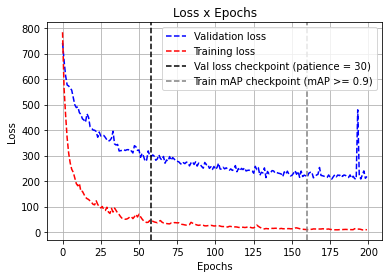

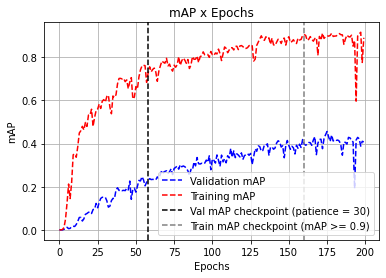

In [13]:
if __name__ == "__main__":
    main()

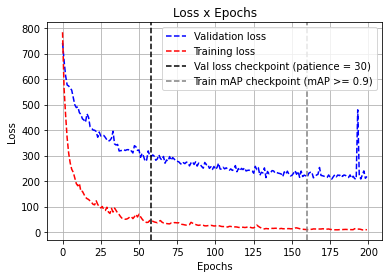

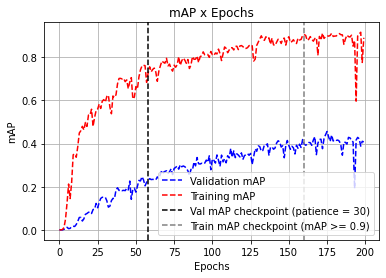

In [14]:
loss_graph()
mAP_graph()

In [ ]:
18:48
19:53